In [1]:
import keras
import scipy
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer

plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize

In [2]:
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[1]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [3]:
df1 = pd.read_csv('../../../_data/Sepulveda_et_al_2020-master/data/perceptual/GlamDataPF2019_Less_NoBin.csv', index_col=0)
df2 = pd.read_csv('../../../_data/Sepulveda_et_al_2020-master/data/perceptual/GlamDataPF2019_More_NoBin.csv', index_col=0)
df1['goal'] = -1
df2['goal'] = 1
data_df = pd.concat([df1, df2]).sort_values(by=['subject', 'trial'])
data_df.reset_index(drop=True, inplace=True)

data_df['rt'] /= 1000

data_df.rename(columns={'subject': 'sbj'}, inplace=True)
data_df['sbj'] = data_df['sbj'].map({data_df['sbj'].unique()[i]:i for i in range(len(data_df['sbj'].unique()))})

mean_rt = data_df.groupby('sbj')['rt'].mean()
std_rt = data_df.groupby('sbj')['rt'].std()
RT_Max = mean_rt + 3 * std_rt

rt_max = []
for i in range(data_df.shape[0]):
    rt_max.append(RT_Max[data_df['sbj'][i]])
data_df['rt_max'] = rt_max
data_df = data_df[(data_df['rt']>0.25) & (data_df['rt']<data_df['rt_max'])].reset_index(drop=True)

data_df.reset_index(drop=True, inplace=True)

data_df['value diff'] = data_df['item_value_1'] - data_df['item_value_0']
kbins = KBinsDiscretizer(n_bins=9, encode='ordinal', strategy='uniform')
data_df['value diff'] = kbins.fit_transform(data_df[['value diff']])
mms = MinMaxScaler(feature_range=(-20, 20))
data_df['Right Value - Left Value'] = mms.fit_transform(data_df[['value diff']])

data_df['gaze diff'] = data_df['gaze_1'] - data_df['gaze_0']
kbins = KBinsDiscretizer(n_bins=9, encode='ordinal', strategy='uniform')
data_df['gaze diff'] = kbins.fit_transform(data_df[['gaze diff']])
mms = MinMaxScaler(feature_range=(-1, 1))
data_df['Dwell Time Advantage (R - L)'] = mms.fit_transform(data_df[['gaze diff']])

min_rt = data_df.groupby(by='sbj')['rt'].min()

In [4]:
tr_df, ts_df = data_df.copy(), data_df.copy()

obs_train = np.asarray(data_df[['rt', 'choice', 'sbj']])
X_train = np.asarray(data_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1', 'goal']])

obs_test = np.asarray(data_df[['rt', 'choice', 'sbj']])
X_test = np.asarray(data_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1', 'goal']])

print(X_train.shape, X_test.shape)

(7555, 5) (7555, 5)


In [5]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):

    sbj_indices = tf.cast(data[:, 2], tf.int32)

    # Gather values directly using TensorFlow operations
    gathered_min_rt = tf.gather(min_rt, sbj_indices)
    sigmoid_weights = tf.gather(model.layers[-1].weights[-1], sbj_indices)
    ndt = gathered_min_rt * tf.math.sigmoid(sigmoid_weights)

    thr_weights = tf.gather(model.layers[-1].weights[-2], sbj_indices)
    thr = tf.math.log(1 + tf.exp(thr_weights))

    scl_weights = tf.gather(model.layers[-1].weights[-3], sbj_indices)
    scl = tf.math.log(1 + tf.exp(scl_weights))

    ll1 = (1 - data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 0]))

    return -2*tf.reduce_sum(tf.math.log(ll1 + ll2 + 0.1**14), axis=-1)

In [6]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [7]:
layers_neuron = [10, 10, 10, 8]
input_shape = 5
output_shape = 2
activation = 'tanh'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                60        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 8)                 88        
                                                                 
 out_layer (Out_layer)       (None, 2)                 114       
                                                                 
Total params: 482 (1.88 KB)
Trainable params: 482 (1.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [8]:
sbj_indices = tf.cast(obs_train[:, 2], tf.int32)
obs_train = tf.cast(obs_train, tf.float32)
X_train = tf.convert_to_tensor(X_train)
X_train = tf.cast(X_train, tf.float32)

min_rt = tf.convert_to_tensor(min_rt)
min_rt = tf.cast(min_rt, tf.float32)

In [9]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=3500)

Epoch 1/3500
1/1 [==============================] - 1s 792ms/step - loss: 73986.1250
Epoch 2/3500
1/1 [==============================] - 0s 7ms/step - loss: 73463.9062
Epoch 3/3500
1/1 [==============================] - 0s 6ms/step - loss: 73116.8594
Epoch 4/3500
1/1 [==============================] - 0s 10ms/step - loss: 72840.1953
Epoch 5/3500
1/1 [==============================] - 0s 7ms/step - loss: 72600.0469
Epoch 6/3500
1/1 [==============================] - 0s 8ms/step - loss: 72379.1562
Epoch 7/3500
1/1 [==============================] - 0s 7ms/step - loss: 72167.4062
Epoch 8/3500
1/1 [==============================] - 0s 8ms/step - loss: 71958.5078
Epoch 9/3500
1/1 [==============================] - 0s 7ms/step - loss: 71751.0312
Epoch 10/3500
1/1 [==============================] - 0s 7ms/step - loss: 71547.5234
Epoch 11/3500
1/1 [==============================] - 0s 5ms/step - loss: 71349.9531
Epoch 12/3500
1/1 [==============================] - 0s 7ms/step - loss: 71157.742

1/1 [==============================] - 0s 7ms/step - loss: 60031.8359
Epoch 99/3500
1/1 [==============================] - 0s 9ms/step - loss: 59952.7734
Epoch 100/3500
1/1 [==============================] - 0s 7ms/step - loss: 59874.4688
Epoch 101/3500
1/1 [==============================] - 0s 8ms/step - loss: 59796.9297
Epoch 102/3500
1/1 [==============================] - 0s 6ms/step - loss: 59720.1484
Epoch 103/3500
1/1 [==============================] - 0s 8ms/step - loss: 59644.1016
Epoch 104/3500
1/1 [==============================] - 0s 7ms/step - loss: 59568.7969
Epoch 105/3500
1/1 [==============================] - 0s 8ms/step - loss: 59494.2109
Epoch 106/3500
1/1 [==============================] - 0s 7ms/step - loss: 59420.3438
Epoch 107/3500
1/1 [==============================] - 0s 7ms/step - loss: 59347.1914
Epoch 108/3500
1/1 [==============================] - 0s 6ms/step - loss: 59274.7344
Epoch 109/3500
1/1 [==============================] - 0s 7ms/step - loss: 59202.9

1/1 [==============================] - 0s 7ms/step - loss: 54886.6992
Epoch 195/3500
1/1 [==============================] - 0s 8ms/step - loss: 54850.2031
Epoch 196/3500
1/1 [==============================] - 0s 7ms/step - loss: 54813.9258
Epoch 197/3500
1/1 [==============================] - 0s 8ms/step - loss: 54777.8672
Epoch 198/3500
1/1 [==============================] - 0s 7ms/step - loss: 54742.0078
Epoch 199/3500
1/1 [==============================] - 0s 7ms/step - loss: 54706.3750
Epoch 200/3500
1/1 [==============================] - 0s 7ms/step - loss: 54670.9414
Epoch 201/3500
1/1 [==============================] - 0s 7ms/step - loss: 54635.7031
Epoch 202/3500
1/1 [==============================] - 0s 6ms/step - loss: 54600.6797
Epoch 203/3500
1/1 [==============================] - 0s 7ms/step - loss: 54565.8555
Epoch 204/3500
1/1 [==============================] - 0s 6ms/step - loss: 54531.2344
Epoch 205/3500
1/1 [==============================] - 0s 8ms/step - loss: 54496.

1/1 [==============================] - 0s 7ms/step - loss: 52084.4609
Epoch 291/3500
1/1 [==============================] - 0s 8ms/step - loss: 52060.4375
Epoch 292/3500
1/1 [==============================] - 0s 8ms/step - loss: 52036.4766
Epoch 293/3500
1/1 [==============================] - 0s 7ms/step - loss: 52012.5938
Epoch 294/3500
1/1 [==============================] - 0s 7ms/step - loss: 51988.7773
Epoch 295/3500
1/1 [==============================] - 0s 7ms/step - loss: 51965.0234
Epoch 296/3500
1/1 [==============================] - 0s 7ms/step - loss: 51941.3555
Epoch 297/3500
1/1 [==============================] - 0s 7ms/step - loss: 51917.7500
Epoch 298/3500
1/1 [==============================] - 0s 9ms/step - loss: 51894.2109
Epoch 299/3500
1/1 [==============================] - 0s 8ms/step - loss: 51870.7383
Epoch 300/3500
1/1 [==============================] - 0s 13ms/step - loss: 51847.3359
Epoch 301/3500
1/1 [==============================] - 0s 10ms/step - loss: 5182

1/1 [==============================] - 0s 7ms/step - loss: 50029.7812
Epoch 387/3500
1/1 [==============================] - 0s 9ms/step - loss: 50010.4375
Epoch 388/3500
1/1 [==============================] - 0s 7ms/step - loss: 49991.1250
Epoch 389/3500
1/1 [==============================] - 0s 8ms/step - loss: 49971.8516
Epoch 390/3500
1/1 [==============================] - 0s 7ms/step - loss: 49952.6055
Epoch 391/3500
1/1 [==============================] - 0s 8ms/step - loss: 49933.3906
Epoch 392/3500
1/1 [==============================] - 0s 7ms/step - loss: 49914.2109
Epoch 393/3500
1/1 [==============================] - 0s 8ms/step - loss: 49895.0625
Epoch 394/3500
1/1 [==============================] - 0s 6ms/step - loss: 49875.9453
Epoch 395/3500
1/1 [==============================] - 0s 8ms/step - loss: 49856.8594
Epoch 396/3500
1/1 [==============================] - 0s 7ms/step - loss: 49837.8008
Epoch 397/3500
1/1 [==============================] - 0s 8ms/step - loss: 49818.

1/1 [==============================] - 0s 6ms/step - loss: 48300.5625
Epoch 483/3500
1/1 [==============================] - 0s 7ms/step - loss: 48283.7266
Epoch 484/3500
1/1 [==============================] - 0s 6ms/step - loss: 48266.9141
Epoch 485/3500
1/1 [==============================] - 0s 7ms/step - loss: 48250.1250
Epoch 486/3500
1/1 [==============================] - 0s 6ms/step - loss: 48233.3594
Epoch 487/3500
1/1 [==============================] - 0s 7ms/step - loss: 48216.6094
Epoch 488/3500
1/1 [==============================] - 0s 7ms/step - loss: 48199.8828
Epoch 489/3500
1/1 [==============================] - 0s 6ms/step - loss: 48183.1797
Epoch 490/3500
1/1 [==============================] - 0s 6ms/step - loss: 48166.4922
Epoch 491/3500
1/1 [==============================] - 0s 7ms/step - loss: 48149.8359
Epoch 492/3500
1/1 [==============================] - 0s 7ms/step - loss: 48133.1953
Epoch 493/3500
1/1 [==============================] - 0s 6ms/step - loss: 48116.

1/1 [==============================] - 0s 11ms/step - loss: 46777.0781
Epoch 579/3500
1/1 [==============================] - 0s 10ms/step - loss: 46762.1406
Epoch 580/3500
1/1 [==============================] - 0s 9ms/step - loss: 46747.2266
Epoch 581/3500
1/1 [==============================] - 0s 10ms/step - loss: 46732.3281
Epoch 582/3500
1/1 [==============================] - 0s 10ms/step - loss: 46717.4453
Epoch 583/3500
1/1 [==============================] - 0s 10ms/step - loss: 46702.5859
Epoch 584/3500
1/1 [==============================] - 0s 10ms/step - loss: 46687.7422
Epoch 585/3500
1/1 [==============================] - 0s 10ms/step - loss: 46672.9141
Epoch 586/3500
1/1 [==============================] - 0s 9ms/step - loss: 46658.1094
Epoch 587/3500
1/1 [==============================] - 0s 10ms/step - loss: 46643.3203
Epoch 588/3500
1/1 [==============================] - 0s 10ms/step - loss: 46628.5430
Epoch 589/3500
1/1 [==============================] - 0s 9ms/step - los

1/1 [==============================] - 0s 10ms/step - loss: 45418.8516
Epoch 675/3500
1/1 [==============================] - 0s 10ms/step - loss: 45405.4609
Epoch 676/3500
1/1 [==============================] - 0s 10ms/step - loss: 45392.0781
Epoch 677/3500
1/1 [==============================] - 0s 9ms/step - loss: 45378.7188
Epoch 678/3500
1/1 [==============================] - 0s 9ms/step - loss: 45365.3594
Epoch 679/3500
1/1 [==============================] - 0s 8ms/step - loss: 45352.0273
Epoch 680/3500
1/1 [==============================] - 0s 10ms/step - loss: 45338.7031
Epoch 681/3500
1/1 [==============================] - 0s 9ms/step - loss: 45325.3906
Epoch 682/3500
1/1 [==============================] - 0s 9ms/step - loss: 45312.0938
Epoch 683/3500
1/1 [==============================] - 0s 12ms/step - loss: 45298.8047
Epoch 684/3500
1/1 [==============================] - 0s 9ms/step - loss: 45285.5312
Epoch 685/3500
1/1 [==============================] - 0s 9ms/step - loss: 4

1/1 [==============================] - 0s 8ms/step - loss: 44187.6250
Epoch 771/3500
1/1 [==============================] - 0s 8ms/step - loss: 44175.2812
Epoch 772/3500
1/1 [==============================] - 0s 10ms/step - loss: 44162.9453
Epoch 773/3500
1/1 [==============================] - 0s 8ms/step - loss: 44150.6094
Epoch 774/3500
1/1 [==============================] - 0s 7ms/step - loss: 44138.2852
Epoch 775/3500
1/1 [==============================] - 0s 8ms/step - loss: 44125.9688
Epoch 776/3500
1/1 [==============================] - 0s 7ms/step - loss: 44113.6484
Epoch 777/3500
1/1 [==============================] - 0s 11ms/step - loss: 44101.3477
Epoch 778/3500
1/1 [==============================] - 0s 9ms/step - loss: 44089.0469
Epoch 779/3500
1/1 [==============================] - 0s 9ms/step - loss: 44076.7500
Epoch 780/3500
1/1 [==============================] - 0s 8ms/step - loss: 44064.4648
Epoch 781/3500
1/1 [==============================] - 0s 7ms/step - loss: 4405

1/1 [==============================] - 0s 7ms/step - loss: 42815.3359
Epoch 867/3500
1/1 [==============================] - 0s 8ms/step - loss: 42798.6016
Epoch 868/3500
1/1 [==============================] - 0s 7ms/step - loss: 42783.3867
Epoch 869/3500
1/1 [==============================] - 0s 8ms/step - loss: 42766.6016
Epoch 870/3500
1/1 [==============================] - 0s 7ms/step - loss: 42751.3789
Epoch 871/3500
1/1 [==============================] - 0s 9ms/step - loss: 42734.5469
Epoch 872/3500
1/1 [==============================] - 0s 7ms/step - loss: 42719.3086
Epoch 873/3500
1/1 [==============================] - 0s 7ms/step - loss: 42702.4375
Epoch 874/3500
1/1 [==============================] - 0s 7ms/step - loss: 42687.1836
Epoch 875/3500
1/1 [==============================] - 0s 8ms/step - loss: 42670.2773
Epoch 876/3500
1/1 [==============================] - 0s 6ms/step - loss: 42655.0156
Epoch 877/3500
1/1 [==============================] - 0s 8ms/step - loss: 42638.

1/1 [==============================] - 0s 8ms/step - loss: 41455.9375
Epoch 963/3500
1/1 [==============================] - 0s 6ms/step - loss: 41443.0273
Epoch 964/3500
1/1 [==============================] - 0s 8ms/step - loss: 41432.6875
Epoch 965/3500
1/1 [==============================] - 0s 6ms/step - loss: 41419.8438
Epoch 966/3500
1/1 [==============================] - 0s 7ms/step - loss: 41409.5938
Epoch 967/3500
1/1 [==============================] - 0s 7ms/step - loss: 41396.8125
Epoch 968/3500
1/1 [==============================] - 0s 8ms/step - loss: 41386.6328
Epoch 969/3500
1/1 [==============================] - 0s 7ms/step - loss: 41373.9219
Epoch 970/3500
1/1 [==============================] - 0s 7ms/step - loss: 41363.8281
Epoch 971/3500
1/1 [==============================] - 0s 7ms/step - loss: 41351.1797
Epoch 972/3500
1/1 [==============================] - 0s 7ms/step - loss: 41341.1641
Epoch 973/3500
1/1 [==============================] - 0s 6ms/step - loss: 41328.

1/1 [==============================] - 0s 7ms/step - loss: 40457.8477
Epoch 1058/3500
1/1 [==============================] - 0s 7ms/step - loss: 40448.6562
Epoch 1059/3500
1/1 [==============================] - 0s 8ms/step - loss: 40437.2500
Epoch 1060/3500
1/1 [==============================] - 0s 8ms/step - loss: 40428.0078
Epoch 1061/3500
1/1 [==============================] - 0s 7ms/step - loss: 40416.5508
Epoch 1062/3500
1/1 [==============================] - 0s 8ms/step - loss: 40407.2383
Epoch 1063/3500
1/1 [==============================] - 0s 8ms/step - loss: 40395.7344
Epoch 1064/3500
1/1 [==============================] - 0s 8ms/step - loss: 40386.3438
Epoch 1065/3500
1/1 [==============================] - 0s 7ms/step - loss: 40374.7852
Epoch 1066/3500
1/1 [==============================] - 0s 9ms/step - loss: 40365.3047
Epoch 1067/3500
1/1 [==============================] - 0s 7ms/step - loss: 40353.6641
Epoch 1068/3500
1/1 [==============================] - 0s 8ms/step - l

1/1 [==============================] - 0s 7ms/step - loss: 39090.4531
Epoch 1153/3500
1/1 [==============================] - 0s 8ms/step - loss: 39078.7539
Epoch 1154/3500
1/1 [==============================] - 0s 6ms/step - loss: 39067.9023
Epoch 1155/3500
1/1 [==============================] - 0s 7ms/step - loss: 39056.2812
Epoch 1156/3500
1/1 [==============================] - 0s 7ms/step - loss: 39045.5391
Epoch 1157/3500
1/1 [==============================] - 0s 7ms/step - loss: 39034.0117
Epoch 1158/3500
1/1 [==============================] - 0s 7ms/step - loss: 39023.3828
Epoch 1159/3500
1/1 [==============================] - 0s 8ms/step - loss: 39011.9375
Epoch 1160/3500
1/1 [==============================] - 0s 7ms/step - loss: 39001.4141
Epoch 1161/3500
1/1 [==============================] - 0s 9ms/step - loss: 38990.0430
Epoch 1162/3500
1/1 [==============================] - 0s 6ms/step - loss: 38979.5898
Epoch 1163/3500
1/1 [==============================] - 0s 8ms/step - l

1/1 [==============================] - 0s 7ms/step - loss: 38148.7344
Epoch 1248/3500
1/1 [==============================] - 0s 8ms/step - loss: 38140.7578
Epoch 1249/3500
1/1 [==============================] - 0s 7ms/step - loss: 38130.6875
Epoch 1250/3500
1/1 [==============================] - 0s 8ms/step - loss: 38122.7500
Epoch 1251/3500
1/1 [==============================] - 0s 8ms/step - loss: 38112.6562
Epoch 1252/3500
1/1 [==============================] - 0s 7ms/step - loss: 38104.7578
Epoch 1253/3500
1/1 [==============================] - 0s 7ms/step - loss: 38094.6406
Epoch 1254/3500
1/1 [==============================] - 0s 7ms/step - loss: 38086.7773
Epoch 1255/3500
1/1 [==============================] - 0s 8ms/step - loss: 38076.6406
Epoch 1256/3500
1/1 [==============================] - 0s 6ms/step - loss: 38068.8086
Epoch 1257/3500
1/1 [==============================] - 0s 7ms/step - loss: 38058.6406
Epoch 1258/3500
1/1 [==============================] - 0s 7ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 37301.9609
Epoch 1343/3500
1/1 [==============================] - 0s 7ms/step - loss: 37289.9531
Epoch 1344/3500
1/1 [==============================] - 0s 7ms/step - loss: 37286.9492
Epoch 1345/3500
1/1 [==============================] - 0s 7ms/step - loss: 37275.0703
Epoch 1346/3500
1/1 [==============================] - 0s 7ms/step - loss: 37271.8984
Epoch 1347/3500
1/1 [==============================] - 0s 7ms/step - loss: 37257.8672
Epoch 1348/3500
1/1 [==============================] - 0s 6ms/step - loss: 37253.8594
Epoch 1349/3500
1/1 [==============================] - 0s 7ms/step - loss: 37241.1719
Epoch 1350/3500
1/1 [==============================] - 0s 7ms/step - loss: 37237.5781
Epoch 1351/3500
1/1 [==============================] - 0s 8ms/step - loss: 37225.6172
Epoch 1352/3500
1/1 [==============================] - 0s 7ms/step - loss: 37222.1758
Epoch 1353/3500
1/1 [==============================] - 0s 8ms/step - l

1/1 [==============================] - 0s 7ms/step - loss: 36643.9961
Epoch 1438/3500
1/1 [==============================] - 0s 12ms/step - loss: 36642.4062
Epoch 1439/3500
1/1 [==============================] - 0s 8ms/step - loss: 36631.4102
Epoch 1440/3500
1/1 [==============================] - 0s 7ms/step - loss: 36630.4414
Epoch 1441/3500
1/1 [==============================] - 0s 7ms/step - loss: 36620.4453
Epoch 1442/3500
1/1 [==============================] - 0s 7ms/step - loss: 36619.5820
Epoch 1443/3500
1/1 [==============================] - 0s 8ms/step - loss: 36609.5000
Epoch 1444/3500
1/1 [==============================] - 0s 7ms/step - loss: 36608.3203
Epoch 1445/3500
1/1 [==============================] - 0s 7ms/step - loss: 36597.9062
Epoch 1446/3500
1/1 [==============================] - 0s 6ms/step - loss: 36596.3281
Epoch 1447/3500
1/1 [==============================] - 0s 8ms/step - loss: 36585.8750
Epoch 1448/3500
1/1 [==============================] - 0s 7ms/step - 

1/1 [==============================] - 0s 6ms/step - loss: 36147.3125
Epoch 1533/3500
1/1 [==============================] - 0s 8ms/step - loss: 36138.9414
Epoch 1534/3500
1/1 [==============================] - 0s 7ms/step - loss: 36140.8750
Epoch 1535/3500
1/1 [==============================] - 0s 9ms/step - loss: 36128.8828
Epoch 1536/3500
1/1 [==============================] - 0s 6ms/step - loss: 36128.0352
Epoch 1537/3500
1/1 [==============================] - 0s 9ms/step - loss: 36116.1094
Epoch 1538/3500
1/1 [==============================] - 0s 6ms/step - loss: 36115.5859
Epoch 1539/3500
1/1 [==============================] - 0s 8ms/step - loss: 36106.0391
Epoch 1540/3500
1/1 [==============================] - 0s 7ms/step - loss: 36106.4062
Epoch 1541/3500
1/1 [==============================] - 0s 7ms/step - loss: 36097.8281
Epoch 1542/3500
1/1 [==============================] - 0s 7ms/step - loss: 36098.4531
Epoch 1543/3500
1/1 [==============================] - 0s 7ms/step - l

1/1 [==============================] - 0s 10ms/step - loss: 35704.0117
Epoch 1628/3500
1/1 [==============================] - 0s 9ms/step - loss: 35703.9219
Epoch 1629/3500
1/1 [==============================] - 0s 11ms/step - loss: 35695.5508
Epoch 1630/3500
1/1 [==============================] - 0s 9ms/step - loss: 35697.1680
Epoch 1631/3500
1/1 [==============================] - 0s 9ms/step - loss: 35689.2266
Epoch 1632/3500
1/1 [==============================] - 0s 9ms/step - loss: 35691.6641
Epoch 1633/3500
1/1 [==============================] - 0s 10ms/step - loss: 35681.7930
Epoch 1634/3500
1/1 [==============================] - 0s 9ms/step - loss: 35682.5820
Epoch 1635/3500
1/1 [==============================] - 0s 11ms/step - loss: 35671.0430
Epoch 1636/3500
1/1 [==============================] - 0s 9ms/step - loss: 35670.9062
Epoch 1637/3500
1/1 [==============================] - 0s 9ms/step - loss: 35660.6367
Epoch 1638/3500
1/1 [==============================] - 0s 10ms/ste

1/1 [==============================] - 0s 10ms/step - loss: 35320.9922
Epoch 1723/3500
1/1 [==============================] - 0s 9ms/step - loss: 35312.0625
Epoch 1724/3500
1/1 [==============================] - 0s 11ms/step - loss: 35313.3125
Epoch 1725/3500
1/1 [==============================] - 0s 10ms/step - loss: 35305.3984
Epoch 1726/3500
1/1 [==============================] - 0s 8ms/step - loss: 35307.7500
Epoch 1727/3500
1/1 [==============================] - 0s 11ms/step - loss: 35299.5195
Epoch 1728/3500
1/1 [==============================] - 0s 9ms/step - loss: 35301.5234
Epoch 1729/3500
1/1 [==============================] - 0s 9ms/step - loss: 35291.7461
Epoch 1730/3500
1/1 [==============================] - 0s 10ms/step - loss: 35292.5234
Epoch 1731/3500
1/1 [==============================] - 0s 11ms/step - loss: 35282.4141
Epoch 1732/3500
1/1 [==============================] - 0s 9ms/step - loss: 35283.0820
Epoch 1733/3500
1/1 [==============================] - 0s 10ms/s

1/1 [==============================] - 0s 8ms/step - loss: 34985.9062
Epoch 1817/3500
1/1 [==============================] - 0s 8ms/step - loss: 34977.3828
Epoch 1818/3500
1/1 [==============================] - 0s 7ms/step - loss: 34978.6836
Epoch 1819/3500
1/1 [==============================] - 0s 8ms/step - loss: 34970.5977
Epoch 1820/3500
1/1 [==============================] - 0s 8ms/step - loss: 34972.4258
Epoch 1821/3500
1/1 [==============================] - 0s 8ms/step - loss: 34965.1016
Epoch 1822/3500
1/1 [==============================] - 0s 9ms/step - loss: 34967.5781
Epoch 1823/3500
1/1 [==============================] - 0s 8ms/step - loss: 34959.8594
Epoch 1824/3500
1/1 [==============================] - 0s 8ms/step - loss: 34960.9609
Epoch 1825/3500
1/1 [==============================] - 0s 7ms/step - loss: 34951.8633
Epoch 1826/3500
1/1 [==============================] - 0s 16ms/step - loss: 34952.5781
Epoch 1827/3500
1/1 [==============================] - 0s 8ms/step - 

1/1 [==============================] - 0s 7ms/step - loss: 34694.5391
Epoch 1912/3500
1/1 [==============================] - 0s 7ms/step - loss: 34696.4727
Epoch 1913/3500
1/1 [==============================] - 0s 8ms/step - loss: 34689.0859
Epoch 1914/3500
1/1 [==============================] - 0s 7ms/step - loss: 34691.3047
Epoch 1915/3500
1/1 [==============================] - 0s 8ms/step - loss: 34683.8203
Epoch 1916/3500
1/1 [==============================] - 0s 7ms/step - loss: 34686.0039
Epoch 1917/3500
1/1 [==============================] - 0s 8ms/step - loss: 34678.4062
Epoch 1918/3500
1/1 [==============================] - 0s 7ms/step - loss: 34680.5469
Epoch 1919/3500
1/1 [==============================] - 0s 9ms/step - loss: 34673.1680
Epoch 1920/3500
1/1 [==============================] - 0s 7ms/step - loss: 34675.4844
Epoch 1921/3500
1/1 [==============================] - 0s 8ms/step - loss: 34668.5469
Epoch 1922/3500
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 7ms/step - loss: 34473.1016
Epoch 2007/3500
1/1 [==============================] - 0s 9ms/step - loss: 34466.0703
Epoch 2008/3500
1/1 [==============================] - 0s 7ms/step - loss: 34469.0547
Epoch 2009/3500
1/1 [==============================] - 0s 8ms/step - loss: 34461.9688
Epoch 2010/3500
1/1 [==============================] - 0s 7ms/step - loss: 34464.9648
Epoch 2011/3500
1/1 [==============================] - 0s 8ms/step - loss: 34458.0156
Epoch 2012/3500
1/1 [==============================] - 0s 7ms/step - loss: 34461.0781
Epoch 2013/3500
1/1 [==============================] - 0s 8ms/step - loss: 34454.3828
Epoch 2014/3500
1/1 [==============================] - 0s 7ms/step - loss: 34457.3125
Epoch 2015/3500
1/1 [==============================] - 0s 8ms/step - loss: 34450.6016
Epoch 2016/3500
1/1 [==============================] - 0s 7ms/step - loss: 34453.2070
Epoch 2017/3500
1/1 [==============================] - 0s 7ms/step - l

1/1 [==============================] - 0s 10ms/step - loss: 34294.3672
Epoch 2102/3500
1/1 [==============================] - 0s 9ms/step - loss: 34297.9609
Epoch 2103/3500
1/1 [==============================] - 0s 7ms/step - loss: 34291.3164
Epoch 2104/3500
1/1 [==============================] - 0s 9ms/step - loss: 34294.8516
Epoch 2105/3500
1/1 [==============================] - 0s 7ms/step - loss: 34288.4414
Epoch 2106/3500
1/1 [==============================] - 0s 8ms/step - loss: 34291.7891
Epoch 2107/3500
1/1 [==============================] - 0s 7ms/step - loss: 34285.1875
Epoch 2108/3500
1/1 [==============================] - 0s 7ms/step - loss: 34288.1875
Epoch 2109/3500
1/1 [==============================] - 0s 8ms/step - loss: 34281.2266
Epoch 2110/3500
1/1 [==============================] - 0s 9ms/step - loss: 34284.1172
Epoch 2111/3500
1/1 [==============================] - 0s 8ms/step - loss: 34276.6328
Epoch 2112/3500
1/1 [==============================] - 0s 7ms/step - 

1/1 [==============================] - 0s 7ms/step - loss: 34070.8750
Epoch 2197/3500
1/1 [==============================] - 0s 8ms/step - loss: 34065.2070
Epoch 2198/3500
1/1 [==============================] - 0s 7ms/step - loss: 34067.1172
Epoch 2199/3500
1/1 [==============================] - 0s 8ms/step - loss: 34061.5859
Epoch 2200/3500
1/1 [==============================] - 0s 8ms/step - loss: 34063.4375
Epoch 2201/3500
1/1 [==============================] - 0s 7ms/step - loss: 34057.9219
Epoch 2202/3500
1/1 [==============================] - 0s 9ms/step - loss: 34059.7109
Epoch 2203/3500
1/1 [==============================] - 0s 7ms/step - loss: 34054.2344
Epoch 2204/3500
1/1 [==============================] - 0s 8ms/step - loss: 34056.0000
Epoch 2205/3500
1/1 [==============================] - 0s 7ms/step - loss: 34050.5391
Epoch 2206/3500
1/1 [==============================] - 0s 8ms/step - loss: 34052.2539
Epoch 2207/3500
1/1 [==============================] - 0s 7ms/step - l

1/1 [==============================] - 0s 8ms/step - loss: 33902.4727
Epoch 2292/3500
1/1 [==============================] - 0s 8ms/step - loss: 33901.8672
Epoch 2293/3500
1/1 [==============================] - 0s 9ms/step - loss: 33899.1562
Epoch 2294/3500
1/1 [==============================] - 0s 7ms/step - loss: 33898.5547
Epoch 2295/3500
1/1 [==============================] - 0s 8ms/step - loss: 33895.8516
Epoch 2296/3500
1/1 [==============================] - 0s 7ms/step - loss: 33895.2031
Epoch 2297/3500
1/1 [==============================] - 0s 7ms/step - loss: 33892.5859
Epoch 2298/3500
1/1 [==============================] - 0s 7ms/step - loss: 33891.9141
Epoch 2299/3500
1/1 [==============================] - 0s 7ms/step - loss: 33889.3945
Epoch 2300/3500
1/1 [==============================] - 0s 7ms/step - loss: 33888.6250
Epoch 2301/3500
1/1 [==============================] - 0s 9ms/step - loss: 33886.1328
Epoch 2302/3500
1/1 [==============================] - 0s 7ms/step - l

1/1 [==============================] - 0s 7ms/step - loss: 33750.5156
Epoch 2387/3500
1/1 [==============================] - 0s 8ms/step - loss: 33749.0195
Epoch 2388/3500
1/1 [==============================] - 0s 6ms/step - loss: 33747.4531
Epoch 2389/3500
1/1 [==============================] - 0s 7ms/step - loss: 33745.8594
Epoch 2390/3500
1/1 [==============================] - 0s 6ms/step - loss: 33744.3672
Epoch 2391/3500
1/1 [==============================] - 0s 7ms/step - loss: 33742.7617
Epoch 2392/3500
1/1 [==============================] - 0s 8ms/step - loss: 33741.2266
Epoch 2393/3500
1/1 [==============================] - 0s 8ms/step - loss: 33739.6562
Epoch 2394/3500
1/1 [==============================] - 0s 8ms/step - loss: 33738.0938
Epoch 2395/3500
1/1 [==============================] - 0s 7ms/step - loss: 33736.5117
Epoch 2396/3500
1/1 [==============================] - 0s 6ms/step - loss: 33734.9492
Epoch 2397/3500
1/1 [==============================] - 0s 7ms/step - l

1/1 [==============================] - 0s 7ms/step - loss: 33605.6445
Epoch 2482/3500
1/1 [==============================] - 0s 8ms/step - loss: 33604.8438
Epoch 2483/3500
1/1 [==============================] - 0s 7ms/step - loss: 33602.4922
Epoch 2484/3500
1/1 [==============================] - 0s 8ms/step - loss: 33601.8867
Epoch 2485/3500
1/1 [==============================] - 0s 7ms/step - loss: 33599.2891
Epoch 2486/3500
1/1 [==============================] - 0s 8ms/step - loss: 33599.0078
Epoch 2487/3500
1/1 [==============================] - 0s 7ms/step - loss: 33596.3281
Epoch 2488/3500
1/1 [==============================] - 0s 7ms/step - loss: 33596.2305
Epoch 2489/3500
1/1 [==============================] - 0s 8ms/step - loss: 33593.3555
Epoch 2490/3500
1/1 [==============================] - 0s 8ms/step - loss: 33593.2109
Epoch 2491/3500
1/1 [==============================] - 0s 7ms/step - loss: 33590.4414
Epoch 2492/3500
1/1 [==============================] - 0s 8ms/step - l

1/1 [==============================] - 0s 7ms/step - loss: 33469.3750
Epoch 2577/3500
1/1 [==============================] - 0s 8ms/step - loss: 33464.9766
Epoch 2578/3500
1/1 [==============================] - 0s 7ms/step - loss: 33466.8438
Epoch 2579/3500
1/1 [==============================] - 0s 9ms/step - loss: 33461.4727
Epoch 2580/3500
1/1 [==============================] - 0s 7ms/step - loss: 33463.0156
Epoch 2581/3500
1/1 [==============================] - 0s 8ms/step - loss: 33458.0938
Epoch 2582/3500
1/1 [==============================] - 0s 7ms/step - loss: 33459.9375
Epoch 2583/3500
1/1 [==============================] - 0s 9ms/step - loss: 33456.5938
Epoch 2584/3500
1/1 [==============================] - 0s 7ms/step - loss: 33458.2812
Epoch 2585/3500
1/1 [==============================] - 0s 7ms/step - loss: 33455.4375
Epoch 2586/3500
1/1 [==============================] - 0s 7ms/step - loss: 33455.8594
Epoch 2587/3500
1/1 [==============================] - 0s 8ms/step - l

1/1 [==============================] - 0s 8ms/step - loss: 33324.5859
Epoch 2672/3500
1/1 [==============================] - 0s 8ms/step - loss: 33325.4688
Epoch 2673/3500
1/1 [==============================] - 0s 8ms/step - loss: 33316.9062
Epoch 2674/3500
1/1 [==============================] - 0s 9ms/step - loss: 33321.4297
Epoch 2675/3500
1/1 [==============================] - 0s 8ms/step - loss: 33321.8672
Epoch 2676/3500
1/1 [==============================] - 0s 8ms/step - loss: 33334.4453
Epoch 2677/3500
1/1 [==============================] - 0s 6ms/step - loss: 33340.1914
Epoch 2678/3500
1/1 [==============================] - 0s 8ms/step - loss: 33338.0859
Epoch 2679/3500
1/1 [==============================] - 0s 7ms/step - loss: 33325.4219
Epoch 2680/3500
1/1 [==============================] - 0s 8ms/step - loss: 33316.3672
Epoch 2681/3500
1/1 [==============================] - 0s 7ms/step - loss: 33307.9766
Epoch 2682/3500
1/1 [==============================] - 0s 7ms/step - l

Epoch 2766/3500
1/1 [==============================] - 0s 9ms/step - loss: 33210.6328
Epoch 2767/3500
1/1 [==============================] - 0s 10ms/step - loss: 33201.1016
Epoch 2768/3500
1/1 [==============================] - 0s 9ms/step - loss: 33198.7578
Epoch 2769/3500
1/1 [==============================] - 0s 9ms/step - loss: 33190.4258
Epoch 2770/3500
1/1 [==============================] - 0s 10ms/step - loss: 33187.5781
Epoch 2771/3500
1/1 [==============================] - 0s 9ms/step - loss: 33184.2734
Epoch 2772/3500
1/1 [==============================] - 0s 9ms/step - loss: 33183.1484
Epoch 2773/3500
1/1 [==============================] - 0s 10ms/step - loss: 33183.2539
Epoch 2774/3500
1/1 [==============================] - 0s 9ms/step - loss: 33182.5078
Epoch 2775/3500
1/1 [==============================] - 0s 10ms/step - loss: 33182.8789
Epoch 2776/3500
1/1 [==============================] - 0s 9ms/step - loss: 33185.1406
Epoch 2777/3500
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 33073.9375
Epoch 2861/3500
1/1 [==============================] - 0s 10ms/step - loss: 33065.1641
Epoch 2862/3500
1/1 [==============================] - 0s 9ms/step - loss: 33070.5469
Epoch 2863/3500
1/1 [==============================] - 0s 10ms/step - loss: 33061.3438
Epoch 2864/3500
1/1 [==============================] - 0s 10ms/step - loss: 33066.1289
Epoch 2865/3500
1/1 [==============================] - 0s 10ms/step - loss: 33057.1250
Epoch 2866/3500
1/1 [==============================] - 0s 10ms/step - loss: 33064.3984
Epoch 2867/3500
1/1 [==============================] - 0s 11ms/step - loss: 33056.5078
Epoch 2868/3500
1/1 [==============================] - 0s 10ms/step - loss: 33061.9883
Epoch 2869/3500
1/1 [==============================] - 0s 10ms/step - loss: 33052.8750
Epoch 2870/3500
1/1 [==============================] - 0s 10ms/step - loss: 33058.0703
Epoch 2871/3500
1/1 [==============================] - 0s 9m

1/1 [==============================] - 0s 10ms/step - loss: 32931.0703
Epoch 2956/3500
1/1 [==============================] - 0s 8ms/step - loss: 32947.5000
Epoch 2957/3500
1/1 [==============================] - 0s 8ms/step - loss: 32929.7070
Epoch 2958/3500
1/1 [==============================] - 0s 9ms/step - loss: 32948.3906
Epoch 2959/3500
1/1 [==============================] - 0s 7ms/step - loss: 32931.1641
Epoch 2960/3500
1/1 [==============================] - 0s 9ms/step - loss: 32954.2539
Epoch 2961/3500
1/1 [==============================] - 0s 8ms/step - loss: 32935.9766
Epoch 2962/3500
1/1 [==============================] - 0s 9ms/step - loss: 32955.3359
Epoch 2963/3500
1/1 [==============================] - 0s 11ms/step - loss: 32926.8828
Epoch 2964/3500
1/1 [==============================] - 0s 7ms/step - loss: 32943.6367
Epoch 2965/3500
1/1 [==============================] - 0s 10ms/step - loss: 32917.3906
Epoch 2966/3500
1/1 [==============================] - 0s 8ms/step 

1/1 [==============================] - 0s 7ms/step - loss: 32854.7070
Epoch 3051/3500
1/1 [==============================] - 0s 7ms/step - loss: 32833.7656
Epoch 3052/3500
1/1 [==============================] - 0s 7ms/step - loss: 32869.6406
Epoch 3053/3500
1/1 [==============================] - 0s 7ms/step - loss: 32819.3828
Epoch 3054/3500
1/1 [==============================] - 0s 8ms/step - loss: 32848.7148
Epoch 3055/3500
1/1 [==============================] - 0s 6ms/step - loss: 32804.2070
Epoch 3056/3500
1/1 [==============================] - 0s 9ms/step - loss: 32834.6289
Epoch 3057/3500
1/1 [==============================] - 0s 8ms/step - loss: 32800.9141
Epoch 3058/3500
1/1 [==============================] - 0s 8ms/step - loss: 32837.4570
Epoch 3059/3500
1/1 [==============================] - 0s 7ms/step - loss: 32806.7031
Epoch 3060/3500
1/1 [==============================] - 0s 9ms/step - loss: 32847.8477
Epoch 3061/3500
1/1 [==============================] - 0s 7ms/step - l

1/1 [==============================] - 0s 7ms/step - loss: 32733.5469
Epoch 3146/3500
1/1 [==============================] - 0s 9ms/step - loss: 32790.6250
Epoch 3147/3500
1/1 [==============================] - 0s 7ms/step - loss: 32727.7832
Epoch 3148/3500
1/1 [==============================] - 0s 8ms/step - loss: nan
Epoch 3149/3500
1/1 [==============================] - 0s 8ms/step - loss: 35435.1406
Epoch 3150/3500
1/1 [==============================] - 0s 7ms/step - loss: 32904.7266
Epoch 3151/3500
1/1 [==============================] - 0s 8ms/step - loss: 32704.0156
Epoch 3152/3500
1/1 [==============================] - 0s 8ms/step - loss: 32649.4434
Epoch 3153/3500
1/1 [==============================] - 0s 7ms/step - loss: 32622.2109
Epoch 3154/3500
1/1 [==============================] - 0s 7ms/step - loss: 32605.5977
Epoch 3155/3500
1/1 [==============================] - 0s 9ms/step - loss: 32593.2344
Epoch 3156/3500
1/1 [==============================] - 0s 7ms/step - loss: 32

1/1 [==============================] - 0s 7ms/step - loss: 32714.0742
Epoch 3242/3500
1/1 [==============================] - 0s 7ms/step - loss: 32640.1152
Epoch 3243/3500
1/1 [==============================] - 0s 7ms/step - loss: 32699.4062
Epoch 3244/3500
1/1 [==============================] - 0s 7ms/step - loss: 32635.0742
Epoch 3245/3500
1/1 [==============================] - 0s 7ms/step - loss: 32688.2598
Epoch 3246/3500
1/1 [==============================] - 0s 8ms/step - loss: 32630.3086
Epoch 3247/3500
1/1 [==============================] - 0s 8ms/step - loss: nan
Epoch 3248/3500
1/1 [==============================] - 0s 7ms/step - loss: 32628.1211
Epoch 3249/3500
1/1 [==============================] - 0s 8ms/step - loss: 32696.9336
Epoch 3250/3500
1/1 [==============================] - 0s 7ms/step - loss: 32640.2285
Epoch 3251/3500
1/1 [==============================] - 0s 8ms/step - loss: 32710.8984
Epoch 3252/3500
1/1 [==============================] - 0s 8ms/step - loss: 32

1/1 [==============================] - 0s 8ms/step - loss: nan
Epoch 3338/3500
1/1 [==============================] - 0s 7ms/step - loss: 32562.5117
Epoch 3339/3500
1/1 [==============================] - 0s 8ms/step - loss: 32624.8750
Epoch 3340/3500
1/1 [==============================] - 0s 8ms/step - loss: 32562.2891
Epoch 3341/3500
1/1 [==============================] - 0s 8ms/step - loss: 32636.8398
Epoch 3342/3500
1/1 [==============================] - 0s 8ms/step - loss: 32561.8652
Epoch 3343/3500
1/1 [==============================] - 0s 8ms/step - loss: 32637.5742
Epoch 3344/3500
1/1 [==============================] - 0s 8ms/step - loss: 32567.2559
Epoch 3345/3500
1/1 [==============================] - 0s 7ms/step - loss: 32645.8164
Epoch 3346/3500
1/1 [==============================] - 0s 8ms/step - loss: 32562.3906
Epoch 3347/3500
1/1 [==============================] - 0s 7ms/step - loss: 32627.9473
Epoch 3348/3500
1/1 [==============================] - 0s 8ms/step - loss: 32

1/1 [==============================] - 0s 7ms/step - loss: 32588.0098
Epoch 3434/3500
1/1 [==============================] - 0s 8ms/step - loss: 32507.0254
Epoch 3435/3500
1/1 [==============================] - 0s 7ms/step - loss: 32593.1660
Epoch 3436/3500
1/1 [==============================] - 0s 8ms/step - loss: 32501.2148
Epoch 3437/3500
1/1 [==============================] - 0s 8ms/step - loss: 32571.9102
Epoch 3438/3500
1/1 [==============================] - 0s 7ms/step - loss: 32487.6875
Epoch 3439/3500
1/1 [==============================] - 0s 8ms/step - loss: 32553.5352
Epoch 3440/3500
1/1 [==============================] - 0s 8ms/step - loss: 32483.6484
Epoch 3441/3500
1/1 [==============================] - 0s 9ms/step - loss: 32558.6367
Epoch 3442/3500
1/1 [==============================] - 0s 7ms/step - loss: 32489.3418
Epoch 3443/3500
1/1 [==============================] - 0s 8ms/step - loss: 32575.5254
Epoch 3444/3500
1/1 [==============================] - 0s 7ms/step - l

In [10]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

237/237 [==============================] - 0s 475us/step


In [11]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'goal':[],
            'value_diff': [],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i-1] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]-1], ndt[ts_df.sbj[s]-1])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['goal'].append(ts_df.goal[s])
        pred_bhv['value_diff'].append(ts_df['Right Value - Left Value'][s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

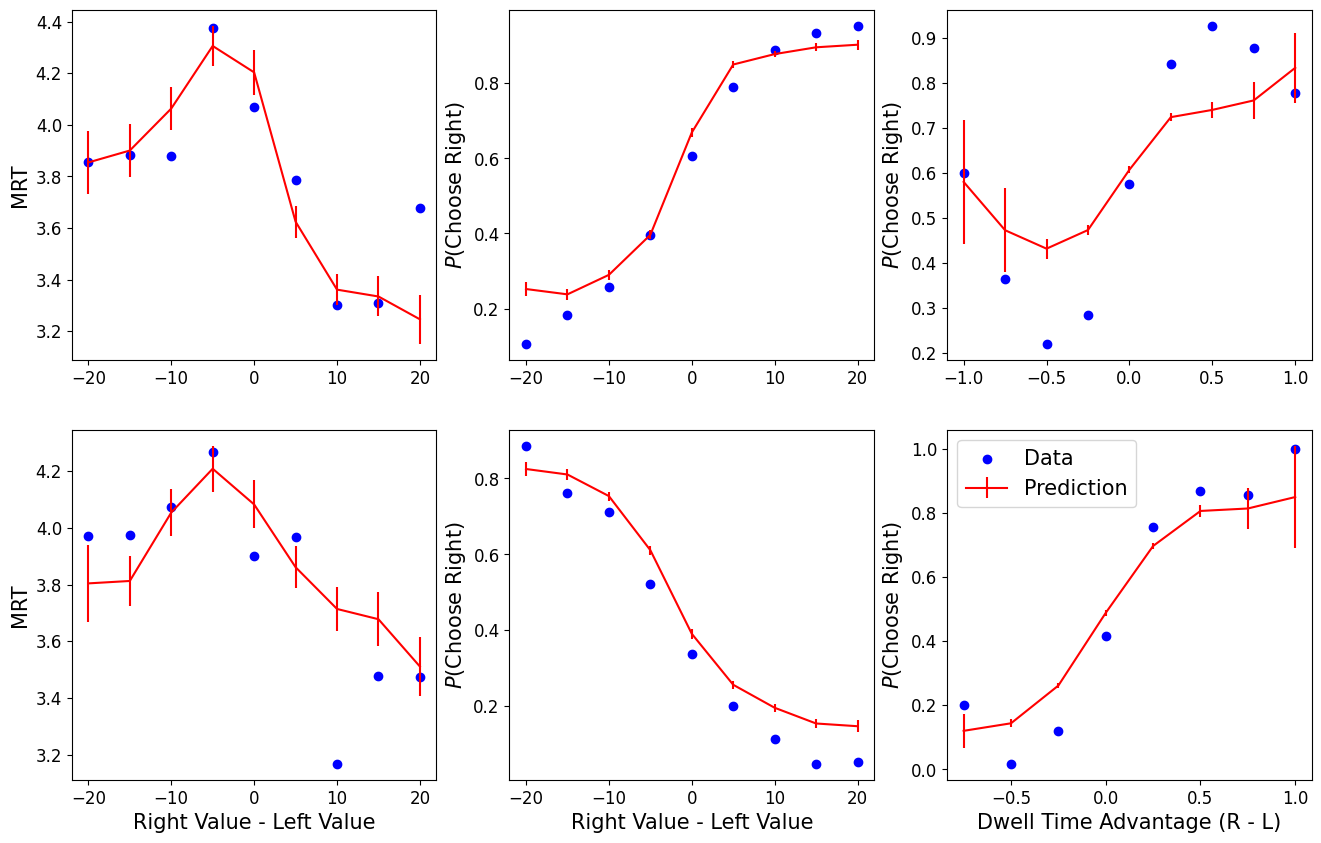

In [12]:
plt.figure(figsize=(16, 10))
plt.subplot(231)
se = pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['rt'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['rt'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['rt'].mean(), c='blue');
plt.ylabel('MRT');

plt.subplot(232)
se = pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['choice'].mean(), c='blue');
plt.ylabel(r'$P$(Choose Right)');

plt.subplot(233)
se = pred_bhv[pred_bhv['goal']==1].groupby(by='gaze_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==1].groupby(by='gaze_diff')['gaze_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==1].groupby(by='gaze_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==1].groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df[ts_df['goal']==1].groupby(by='Dwell Time Advantage (R - L)')['choice'].mean(), c='blue');
plt.ylabel(r'$P$(Choose Right)');

###########
plt.subplot(234)
se = pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['rt'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==-1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['rt'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['rt'].mean(), c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel('MRT');

plt.subplot(235)
se = pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==-1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['choice'].mean(), c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel(r'$P$(Choose Right)');

plt.subplot(236)
se = pred_bhv[pred_bhv['goal']==-1].groupby(by='gaze_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==-1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==-1].groupby(by='gaze_diff')['gaze_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==-1].groupby(by='gaze_diff')['ch'].mean(),
             yerr=h, label='Prediction', c='red');
plt.scatter(x=ts_df[ts_df['goal']==-1].groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df[ts_df['goal']==-1].groupby(by='Dwell Time Advantage (R - L)')['choice'].mean(), c='blue', label='Data');
plt.xlabel('Dwell Time Advantage (R - L)');
plt.ylabel(r'$P$(Choose Right)');
plt.legend();

plt.savefig('_plots/sp2020_perceptual_complete_postpred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');

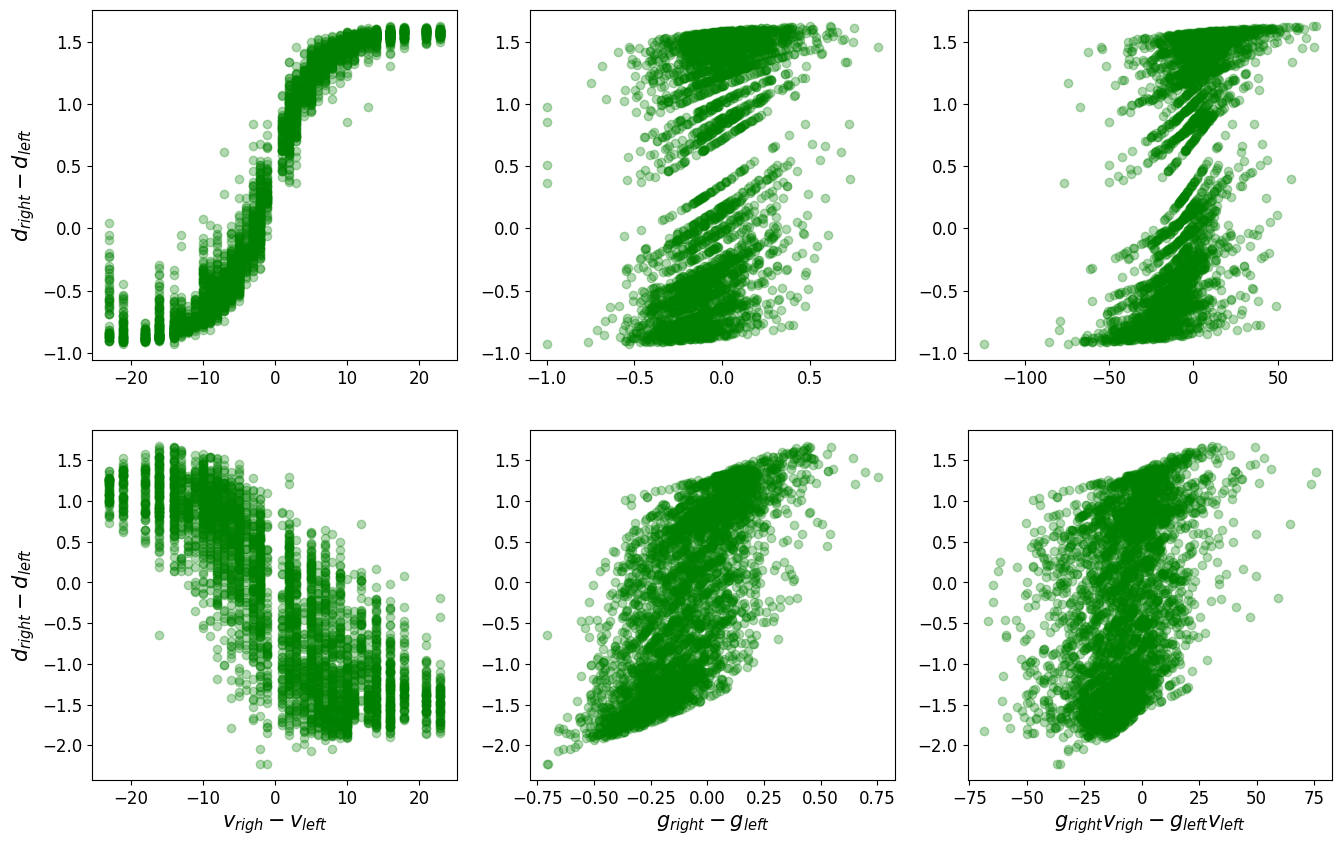

In [13]:
plt.figure(figsize=(16, 10))
plt.subplot(231)
plt.scatter(X_test[X_test[:, -1]==1, 1] - X_test[X_test[:, -1]==1, 0], 
            pred_v[X_test[:, -1]==1, 1] - pred_v[X_test[:, -1]==1, 0], 
            alpha=0.3, c='green');
plt.ylabel(r'$d_{right} - d_{left}$');

plt.subplot(232)
plt.scatter(X_test[X_test[:, -1]==1, 3] - X_test[X_test[:, -1]==1, 2], 
            pred_v[X_test[:, -1]==1, 1] - pred_v[X_test[:, -1]==1, 0], 
            alpha=0.3, c='green');


plt.subplot(233)
plt.scatter(X_test[X_test[:, -1]==1, 1]*X_test[X_test[:, -1]==1, 3] - X_test[X_test[:, -1]==1, 0]*X_test[X_test[:, -1]==1, 2], 
            pred_v[X_test[:, -1]==1, 1] - pred_v[X_test[:, -1]==1, 0], 
            alpha=0.3, c='green');

#####################
plt.subplot(234)
plt.scatter(X_test[X_test[:, -1]==-1, 1] - X_test[X_test[:, -1]==-1, 0], 
            pred_v[X_test[:, -1]==-1, 1] - pred_v[X_test[:, -1]==-1, 0], 
            alpha=0.3, c='green');
plt.xlabel(r'$v_{righ} - v_{left}$ ');
plt.ylabel(r'$d_{right} - d_{left}$');

plt.subplot(235)
plt.scatter(X_test[X_test[:, -1]==-1, 3] - X_test[X_test[:, -1]==-1, 2], 
            pred_v[X_test[:, -1]==-1, 1] - pred_v[X_test[:, -1]==-1, 0], 
            alpha=0.3, c='green');
plt.xlabel(r'$g_{right} - g_{left}$ ');

plt.subplot(236)
plt.scatter(X_test[X_test[:, -1]==-1, 1]*X_test[X_test[:, -1]==-1, 3] - X_test[X_test[:, -1]==-1, 0]*X_test[X_test[:, -1]==-1, 2], 
            pred_v[X_test[:, -1]==-1, 1] - pred_v[X_test[:, -1]==-1, 0], 
            alpha=0.3, c='green');
plt.xlabel(r'$g_{right} v_{righ} - g_{left} v_{left}$ ');

plt.savefig('_plots/sp2020_perceptual_complete_prmspred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');